### **IMPORT**

In [ ]:
# Common imports
import numpy as np
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.metrics import f1_score, recall_score, precision_score
import tensorflow as tf

from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils.np_utils import to_categorical
from keras.utils.data_utils import get_file
from keras.callbacks import Callback
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
import keras.backend as K
from keras import backend as K


import copy
from tensorflow.keras import optimizers
import keras
import numpy as np
from keras.datasets import mnist
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.noise import GaussianNoise
from keras.layers import SpatialDropout2D
from keras import regularizers
import matplotlib.pyplot as plt

### **DROPBLOCK FUNCTION**
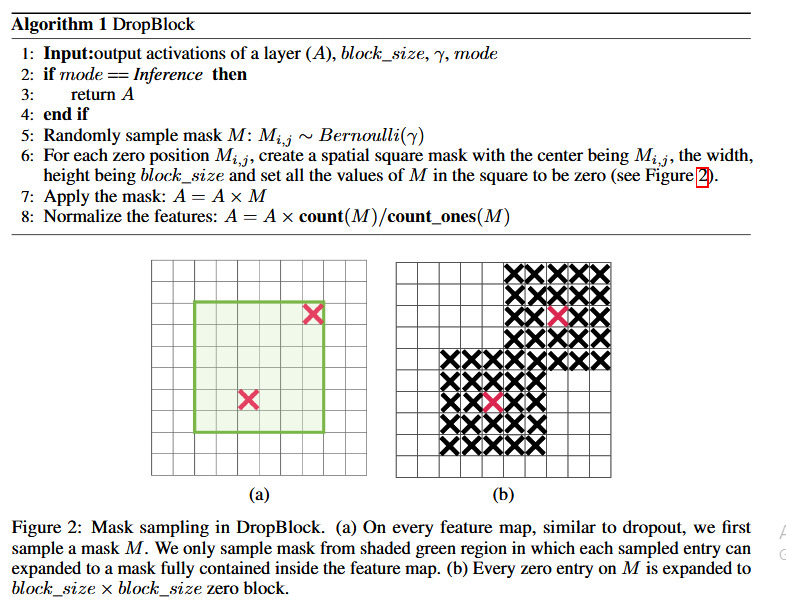


In [ ]:
from keras import backend as K


import copy

class NN_DropBlock(tf.keras.layers.Layer):

    def __init__(self, block_size, keep_prob, **kwargs):
        super(NN_DropBlock, self).__init__(**kwargs)
        self.block_size = block_size
        self.keep_prob = keep_prob

    def call(self, x, inference=None):

        # During inference, we do not Drop Blocks
        if inference == None:
            return x

        #padding
        z = self.block_size//2

        # Calculate Gamma
        feature_size = int(x.shape[-1])
        gamma = ((1-self.keep_prob)/(self.block_size**2)) * ((feature_size**2) / ((feature_size-self.block_size+1)**2))

        # Randomly sample mask
        sample_mask = tf.nn.relu(tf.sign(gamma - tf.random_uniform((feature_size-(z*2), feature_size-(z*2)), minval=0, maxval=1, dtype=tf.float32)))

        # The above code creates a matrix of zeros and samples ones from the distribution
        # We would like to flip all of these values
        sample_mask = 1-sample_mask

        # Pad the mask with ones
        sample_mask = np.pad(sample_mask, pad_width=z, mode='constant', constant_values=1)

        # For each 0, create spatial square mask of shape (block_size x block_size)
        spatial_square_mask = copy.copy(sample_mask)
        for i in range(feature_size):
            for j in range(feature_size):
                if sample_mask[i, j]==0:
                    spatial_square_mask[i-z : i+z+1, j-z : j+z+1] = 0

        spatial_square_mask = spatial_square_mask.reshape((1, feature_size, feature_size))

        # Apply the mask
        x = x * np.repeat(spatial_square_mask, x.shape[1], 0)

        # Normalize the features
        count = np.prod(spatial_square_mask.shape)
        count_ones = np.count_nonzero(spatial_square_mask == 1)
        x = x * count / count_ones

        return x

    def get_config(self):
        config = {'block_size': self.block_size,
                  'keep_prob': self.keep_prob
                  }
        base_config = super(NN_DropBlock, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape


### **CALLBACK FUNCTION**

In [ ]:
class myCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch,logs={}):
        for i in range(31):
          s = str(i)
          # vary the rate wrt epochs. That's what you want
          self.model.get_layer(name = s).keep_prob -= 0.07

### **IDENTITY BLOCK**

In [ ]:
#identity_block

def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    
    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

### **CONV_BLOCK**

In [ ]:
#convolutional_block
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a',padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(F2, (f, f), strides = (1,1), name = conv_name_base + '2b', padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(F3, (1, 1), strides = (1,1), name = conv_name_base + '2c', padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

### **RESNET**

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 32)   4736        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 32)   128         conv1[0][0]                      
___________________________________________________________________________________________

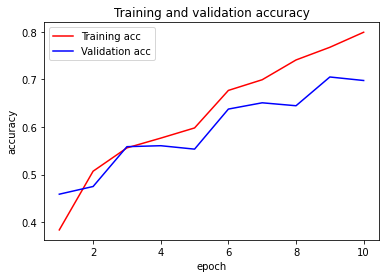

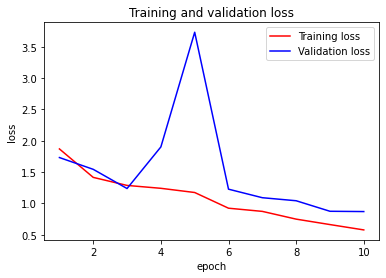

In [ ]:
def ResNet50(input_shape, classes):
    """    
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [32, 32, 128], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [32, 32, 128], stage=2, block='b')
    X = identity_block(X, 3, [32, 32, 128], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [64, 64, 256], stage=3, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=3, block='c')
    X = identity_block(X, 3, [64, 64, 256], stage=3, block='d')

    # Stage 4 
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='d')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='e')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='f')

    # Stage 5 
    X = convolutional_block(X, f = 3, filters = [256,256, 1024], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [256,256, 1024], stage=5, block='b')
    X = identity_block(X, 3, [256,256, 1024], stage=5, block='c')

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2,2), name='avg_pool')(X)
    

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

model = ResNet50(input_shape = (32, 32, 3), classes = 10)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

batch_size = 32
epochs = 10
num_classes = 10
# 3. LOADING TRAINING AND TEST SETS

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data() # data splitting into training and test sets
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples') # number of samples in the training set
print(x_test.shape[0], 'test samples')
input_shape=x_train.shape[1:]

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes) # y=2 ---> (0,0,1,0,0,...)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True
              )

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

acc1 = history.history['accuracy']
val_acc1 = history.history['val_accuracy']
loss1 = history.history['loss']
val_loss1 = history.history['val_loss']
print(acc1)
print(val_acc1)
print(loss1)
print(val_loss1)

epochs = range(1, len(acc1) + 1)

plt.plot(epochs, acc1, 'r', label='Training acc')
plt.plot(epochs, val_acc1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.figure()

plt.plot(epochs, loss1, 'r', label='Training loss')
plt.plot(epochs, val_loss1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.show()

### **IDENTITY BLOCK** per Dropout(0.25)

In [ ]:
#identity_block

def identity_block1(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    X = Dropout(0.25)(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    X = Dropout(0.25)(X)
    
    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

### **CONV_BLOCK** per Dropout(0.25)

In [ ]:
#convolutional_block
def convolutional_block1(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a',padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    X = Dropout(0.25)(X)

    # Second component of main path
    X = Conv2D(F2, (f, f), strides = (1,1), name = conv_name_base + '2b', padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    X = Dropout(0.25)(X)

    # Third component of main path
    X = Conv2D(F3, (1, 1), strides = (1,1), name = conv_name_base + '2c', padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

### **DROPOUT(0.25)**

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 38, 38, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 32)   4736        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 32)   128         conv1[0][0]                      
___________________________________________________________________________________________

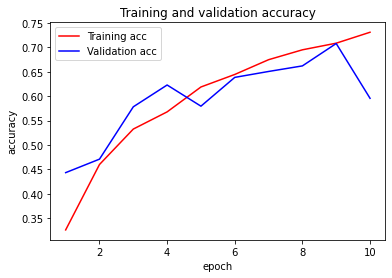

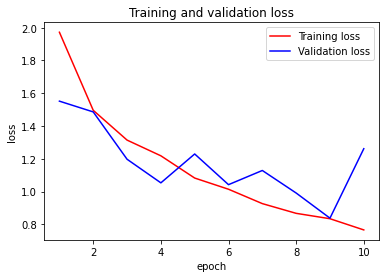

In [ ]:
def ResNet50(input_shape, classes):
    """    
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3))(X)

    # Stage 2
    X = convolutional_block1(X, f = 3, filters = [32, 32, 128], stage = 2, block='a', s = 1)
    X = identity_block1(X, 3, [32, 32, 128], stage=2, block='b')
    X = identity_block1(X, 3, [32, 32, 128], stage=2, block='c')

    # Stage 3
    X = convolutional_block1(X, f = 3, filters = [64, 64, 256], stage = 3, block='a', s = 2)
    X = identity_block1(X, 3, [64, 64, 256], stage=3, block='b')
    X = identity_block1(X, 3, [64, 64, 256], stage=3, block='c')
    X = identity_block1(X, 3, [64, 64, 256], stage=3, block='d')

    # Stage 4 
    X = convolutional_block1(X, f = 3, filters = [128, 128, 512], stage = 4, block='a', s = 2)
    X = identity_block1(X, 3, [128, 128, 512], stage=4, block='b')
    X = identity_block1(X, 3, [128, 128, 512], stage=4, block='c')
    X = identity_block1(X, 3, [128, 128, 512], stage=4, block='d')
    X = identity_block1(X, 3, [128, 128, 512], stage=4, block='e')
    X = identity_block1(X, 3, [128, 128, 512], stage=4, block='f')

    # Stage 5 
    X = convolutional_block1(X, f = 3, filters = [256,256, 1024], stage = 5, block='a', s = 2)
    X = identity_block1(X, 3, [256,256, 1024], stage=5, block='b')
    X = identity_block1(X, 3, [256,256, 1024], stage=5, block='c')

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2,2), name='avg_pool')(X)
    

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

model = ResNet50(input_shape = (32, 32, 3), classes = 10)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

batch_size = 32
epochs = 10
num_classes = 10
# 3. LOADING TRAINING AND TEST SETS

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data() # data splitting into training and test sets
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples') # number of samples in the training set
print(x_test.shape[0], 'test samples')
input_shape=x_train.shape[1:]

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes) # y=2 ---> (0,0,1,0,0,...)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True
              )

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

acc2 = history.history['accuracy']
val_acc2 = history.history['val_accuracy']
loss2 = history.history['loss']
val_loss2 = history.history['val_loss']

print(acc2)
print(val_acc2)
print(loss2)
print(val_loss2)

epochs = range(1, len(acc2) + 1)

plt.plot(epochs, acc2, 'r', label='Training acc')
plt.plot(epochs, val_acc2, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.figure()

plt.plot(epochs, loss2, 'r', label='Training loss')
plt.plot(epochs, val_loss2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.show()

### **IDENTITY BLOCK** per Spatial(0.7)

In [ ]:
#identity_block

def identity_block3(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    X = SpatialDropout2D(0.7)(X)

    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    X = SpatialDropout2D(0.7)(X)
       
    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

### **CONV_BLOCK** per Spatial(0.7)

In [ ]:
#convolutional_block
def convolutional_block3(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a',padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    X = SpatialDropout2D(0.7)(X)

    # Second component of main path
    X = Conv2D(F2, (f, f), strides = (1,1), name = conv_name_base + '2b', padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    X = SpatialDropout2D(0.7)(X)

    # Third component of main path
    X = Conv2D(F3, (1, 1), strides = (1,1), name = conv_name_base + '2c', padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

### **SPATIAL**

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 38, 38, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 32)   4736        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 32)   128         conv1[0][0]                      
___________________________________________________________________________________________

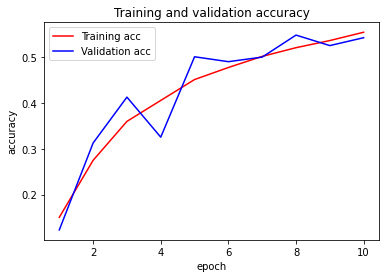

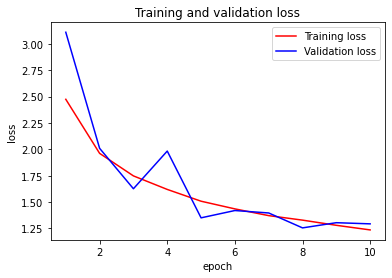

In [ ]:
def ResNet50(input_shape, classes):
    """    
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3))(X)

    # Stage 2
    X = convolutional_block3(X, f = 3, filters = [32, 32, 128], stage = 2, block='a', s = 1)
    X = identity_block3(X, 3, [32, 32, 128], stage=2, block='b')
    X = identity_block3(X, 3, [32, 32, 128], stage=2, block='c')

    # Stage 3
    X = convolutional_block3(X, f = 3, filters = [64, 64, 256], stage = 3, block='a', s = 2)
    X = identity_block3(X, 3, [64, 64, 256], stage=3, block='b')
    X = identity_block3(X, 3, [64, 64, 256], stage=3, block='c')
    X = identity_block3(X, 3, [64, 64, 256], stage=3, block='d')

    # Stage 4 
    X = convolutional_block3(X, f = 3, filters = [128, 128, 512], stage = 4, block='a', s = 2)
    X = identity_block3(X, 3, [128, 128, 512], stage=4, block='b')
    X = identity_block3(X, 3, [128, 128, 512], stage=4, block='c')
    X = identity_block3(X, 3, [128, 128, 512], stage=4, block='d')
    X = identity_block3(X, 3, [128, 128, 512], stage=4, block='e')
    X = identity_block3(X, 3, [128, 128, 512], stage=4, block='f')

    # Stage 5 
    X = convolutional_block3(X, f = 3, filters = [256,256, 1024], stage = 5, block='a', s = 2)
    X = identity_block3(X, 3, [256,256, 1024], stage=5, block='b')
    X = identity_block3(X, 3, [256,256, 1024], stage=5, block='c')

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2,2), name='avg_pool')(X)
    

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

model = ResNet50(input_shape = (32, 32, 3), classes = 10)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

batch_size = 32
epochs = 10
num_classes = 10
# 3. LOADING TRAINING AND TEST SETS

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data() # data splitting into training and test sets
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples') # number of samples in the training set
print(x_test.shape[0], 'test samples')
input_shape=x_train.shape[1:]

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes) # y=2 ---> (0,0,1,0,0,...)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True
              )

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

acc3 = history.history['accuracy']
val_acc3 = history.history['val_accuracy']
loss3 = history.history['loss']
val_loss3 = history.history['val_loss']

print(acc3)
print(val_acc3)
print(loss3)
print(val_loss3)

epochs = range(1, len(acc3) + 1)

plt.plot(epochs, acc3, 'r', label='Training acc')
plt.plot(epochs, val_acc3, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.figure()

plt.plot(epochs, loss3, 'r', label='Training loss')
plt.plot(epochs, val_loss3, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.show()

###**IDENTITY BLOCK** per DropBlock

In [ ]:
#identity_block

def identity_block2(c, X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    X = NN_DropBlock(block_size=3, keep_prob=0.7, name = str(c[0]))(X)
    c[0] += 1
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    X = NN_DropBlock(block_size=3, keep_prob=0.7, name = str(c[0]))(X)
    c[0] += 1
    
    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

### **CONV_BLOCK** per DropBlock

In [ ]:
#convolutional_block
def convolutional_block2(c, X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a',padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    X = NN_DropBlock(block_size=3, keep_prob=0.7, name = str(c[0]))(X)
    c[0] += 1

    # Second component of main path
    X = Conv2D(F2, (f, f), strides = (1,1), name = conv_name_base + '2b', padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    X = NN_DropBlock(block_size=3, keep_prob=0.7, name = str(c[0]))(X)
    c[0] += 1

    # Third component of main path
    X = Conv2D(F3, (1, 1), strides = (1,1), name = conv_name_base + '2c', padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

### **DROPBLOCK**

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 38, 38, 3)    0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 32)   4736        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 32)   128         conv1[0][0]                      
___________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return py_builtins.overload_of(f)(*args)


1563/1563 [==============================] - 174s 90ms/step - loss: 2.3303 - accuracy: 0.2385 - val_loss: 3.6445 - val_accuracy: 0.2560
Epoch 2/10
1563/1563 [==============================] - 135s 87ms/step - loss: 1.6447 - accuracy: 0.4140 - val_loss: 4.6437 - val_accuracy: 0.3564
Epoch 3/10
1563/1563 [==============================] - 136s 87ms/step - loss: 1.4431 - accuracy: 0.4834 - val_loss: 1.2591 - val_accuracy: 0.5517
Epoch 4/10
1563/1563 [==============================] - 137s 87ms/step - loss: 1.2471 - accuracy: 0.5562 - val_loss: 1.2944 - val_accuracy: 0.5435
Epoch 5/10
1563/1563 [==============================] - 135s 86ms/step - loss: 1.0952 - accuracy: 0.6160 - val_loss: 1.4168 - val_accuracy: 0.5626
Epoch 6/10
1563/1563 [==============================] - 136s 87ms/step - loss: 0.9813 - accuracy: 0.6562 - val_loss: 1.0488 - val_accuracy: 0.6380
Epoch 7/10
1563/1563 [==============================] - 136s 87ms/step - loss: 0.8543 - accuracy: 0.7015 - val_loss: 2.7671 - val

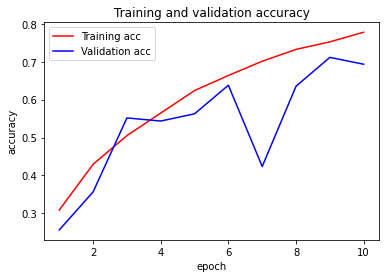

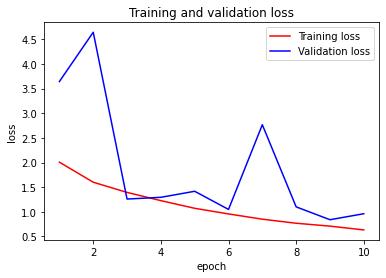

In [ ]:
def ResNet50(c, input_shape, classes):
    """    
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3))(X)

    # Stage 2
    X = convolutional_block2(c, X, f = 3, filters = [32, 32, 128], stage = 2, block='a', s = 1)
    X = identity_block2(c, X, 3, [32, 32, 128], stage=2, block='b')
    X = identity_block2(c, X, 3, [32, 32, 128], stage=2, block='c')

    # Stage 3
    X = convolutional_block2(c, X, f = 3, filters = [64, 64, 256], stage = 3, block='a', s = 2)
    X = identity_block2(c, X, 3, [64, 64, 256], stage=3, block='b')
    X = identity_block2(c, X, 3, [64, 64, 256], stage=3, block='c')
    X = identity_block2(c, X, 3, [64, 64, 256], stage=3, block='d')

    # Stage 4 
    X = convolutional_block2(c, X, f = 3, filters = [128, 128, 512], stage = 4, block='a', s = 2)
    X = identity_block2(c, X, 3, [128, 128, 512], stage=4, block='b')
    X = identity_block2(c, X, 3, [128, 128, 512], stage=4, block='c')
    X = identity_block2(c, X, 3, [128, 128, 512], stage=4, block='d')
    X = identity_block2(c, X, 3, [128, 128, 512], stage=4, block='e')
    X = identity_block2(c, X, 3, [128, 128, 512], stage=4, block='f')

    # Stage 5 
    X = convolutional_block2(c, X, f = 3, filters = [256,256, 1024], stage = 5, block='a', s = 2)
    X = identity_block2(c, X, 3, [256,256, 1024], stage=5, block='b')
    X = identity_block2(c, X, 3, [256,256, 1024], stage=5, block='c')

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2,2), name='avg_pool')(X)
    

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model
c = [0]
model = ResNet50(c, input_shape = (32, 32, 3), classes = 10)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

batch_size = 32
epochs = 10
num_classes = 10
# 3. LOADING TRAINING AND TEST SETS

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data() # data splitting into training and test sets
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples') # number of samples in the training set
print(x_test.shape[0], 'test samples')
input_shape=x_train.shape[1:]

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes) # y=2 ---> (0,0,1,0,0,...)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks = myCallback())

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

acc4 = history.history['accuracy']
val_acc4 = history.history['val_accuracy']
loss4 = history.history['loss']
val_loss4 = history.history['val_loss']
print(acc4)
print(val_acc4)
print(loss4)
print(val_loss4)

epochs = range(1, len(acc4) + 1)

plt.plot(epochs, acc4, 'r', label='Training acc')
plt.plot(epochs, val_acc4, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.figure()

plt.plot(epochs, loss4, 'r', label='Training loss')
plt.plot(epochs, val_loss4, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.show()

###**IDENTITY BLOCK** per DropBlock7

In [ ]:
#identity_block

def identity_block3(c, X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    X = NN_DropBlock(block_size=7, keep_prob=0.7, name = str(c[0]))(X)
    c[0] += 1
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    X = NN_DropBlock(block_size=7, keep_prob=0.7, name = str(c[0]))(X)
    c[0] += 1
    
    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

### **CONV_BLOCK** per DropBlock7

In [ ]:
#convolutional_block
def convolutional_block3(c, X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a',padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    X = NN_DropBlock(block_size=7, keep_prob=0.7, name = str(c[0]))(X)
    c[0] += 1

    # Second component of main path
    X = Conv2D(F2, (f, f), strides = (1,1), name = conv_name_base + '2b', padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    X = NN_DropBlock(block_size=7, keep_prob=0.7, name = str(c[0]))(X)
    c[0] += 1

    # Third component of main path
    X = Conv2D(F3, (1, 1), strides = (1,1), name = conv_name_base + '2c', padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

### **DROPBLOCK**7

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 32)   4736        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 32)   128         conv1[0][0]                      
___________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return py_builtins.overload_of(f)(*args)


1563/1563 [==============================] - 146s 49ms/step - loss: 2.2632 - accuracy: 0.2786 - val_loss: 1.5950 - val_accuracy: 0.3980
Epoch 2/10
1563/1563 [==============================] - 71s 46ms/step - loss: 1.6128 - accuracy: 0.4304 - val_loss: 10.4695 - val_accuracy: 0.1659
Epoch 3/10
1563/1563 [==============================] - 71s 45ms/step - loss: 1.4730 - accuracy: 0.4766 - val_loss: 1.3700 - val_accuracy: 0.5009
Epoch 4/10
1563/1563 [==============================] - 71s 45ms/step - loss: 1.2846 - accuracy: 0.5505 - val_loss: 1.1680 - val_accuracy: 0.5917
Epoch 5/10
1563/1563 [==============================] - 70s 45ms/step - loss: 1.1164 - accuracy: 0.6102 - val_loss: 1.0467 - val_accuracy: 0.6271
Epoch 6/10
1563/1563 [==============================] - 70s 45ms/step - loss: 1.1806 - accuracy: 0.5943 - val_loss: 1.3491 - val_accuracy: 0.5442
Epoch 7/10
1563/1563 [==============================] - 71s 45ms/step - loss: 0.9572 - accuracy: 0.6641 - val_loss: 0.9353 - val_accu

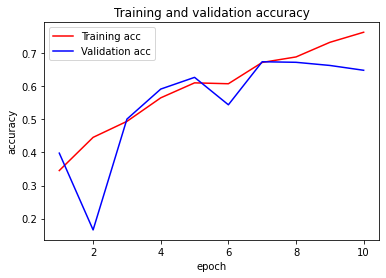

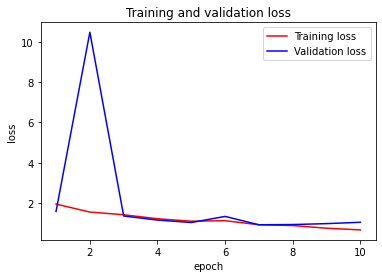

In [ ]:
def ResNet50(c, input_shape, classes):
    """    
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3))(X)

    # Stage 2
    X = convolutional_block3(c, X, f = 3, filters = [32, 32, 128], stage = 2, block='a', s = 1)
    X = identity_block3(c, X, 3, [32, 32, 128], stage=2, block='b')
    X = identity_block3(c, X, 3, [32, 32, 128], stage=2, block='c')

    # Stage 3
    X = convolutional_block3(c, X, f = 3, filters = [64, 64, 256], stage = 3, block='a', s = 2)
    X = identity_block3(c, X, 3, [64, 64, 256], stage=3, block='b')
    X = identity_block3(c, X, 3, [64, 64, 256], stage=3, block='c')
    X = identity_block3(c, X, 3, [64, 64, 256], stage=3, block='d')

    # Stage 4 
    X = convolutional_block3(c, X, f = 3, filters = [128, 128, 512], stage = 4, block='a', s = 2)
    X = identity_block3(c, X, 3, [128, 128, 512], stage=4, block='b')
    X = identity_block3(c, X, 3, [128, 128, 512], stage=4, block='c')
    X = identity_block3(c, X, 3, [128, 128, 512], stage=4, block='d')
    X = identity_block3(c, X, 3, [128, 128, 512], stage=4, block='e')
    X = identity_block3(c, X, 3, [128, 128, 512], stage=4, block='f')

    # Stage 5 
    X = convolutional_block3(c, X, f = 3, filters = [256,256, 1024], stage = 5, block='a', s = 2)
    X = identity_block3(c, X, 3, [256,256, 1024], stage=5, block='b')
    X = identity_block3(c, X, 3, [256,256, 1024], stage=5, block='c')

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2,2), name='avg_pool')(X)
    

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model
c = [0]
model = ResNet50(c, input_shape = (32, 32, 3), classes = 10)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

batch_size = 32
epochs = 10
num_classes = 10
# 3. LOADING TRAINING AND TEST SETS

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data() # data splitting into training and test sets
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples') # number of samples in the training set
print(x_test.shape[0], 'test samples')
input_shape=x_train.shape[1:]

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes) # y=2 ---> (0,0,1,0,0,...)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks = myCallback())

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

acc5 = history.history['accuracy']
val_acc5 = history.history['val_accuracy']
loss5 = history.history['loss']
val_loss5 = history.history['val_loss']

print(acc5)
print(val_acc5)
print(loss5)
print(val_loss5)

epochs = range(1, len(acc5) + 1)

print(epochs)

plt.plot(epochs, acc5, 'r', label='Training acc')
plt.plot(epochs, val_acc5, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.figure()

plt.plot(epochs, loss5, 'r', label='Training loss')
plt.plot(epochs, val_loss5, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.show()

### **MERGE RESULTS**

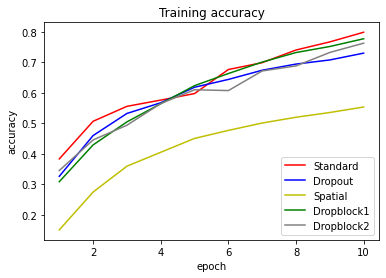

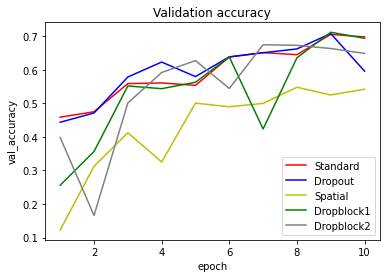

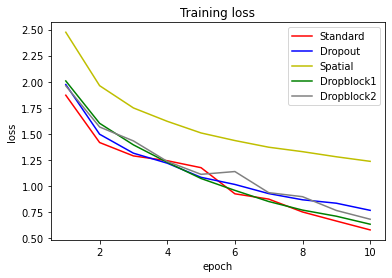

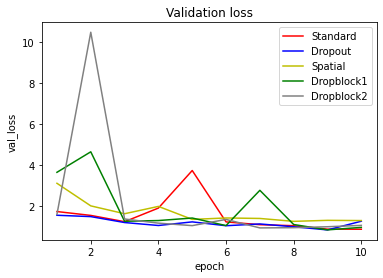

In [ ]:
acc1 = [0.3834399878978729, 0.5069800019264221, 0.5560600161552429, 0.5765600204467773, 0.5979999899864197, 0.6769599914550781, 0.6994199752807617, 0.7410200238227844, 0.7676799893379211, 0.799340009689331]
val_acc1 = [0.4586000144481659, 0.4747999906539917, 0.5586000084877014, 0.5605999827384949, 0.5533999800682068, 0.6377000212669373, 0.6509000062942505, 0.6446999907493591, 0.7052000164985657, 0.6977999806404114]
loss1 = [1.8700859546661377, 1.416294813156128, 1.2879198789596558, 1.2418984174728394, 1.1749712228775024, 0.9245277047157288, 0.8738127946853638, 0.7502263188362122, 0.6633831858634949, 0.5781379342079163]
val_loss1 = [1.7325544357299805, 1.5446386337280273, 1.2383185625076294, 1.9022191762924194, 3.7316582202911377, 1.2280738353729248, 1.0919864177703857, 1.043460488319397, 0.8755096793174744, 0.8708996176719666]
acc2 = [0.3262999951839447, 0.4601399898529053, 0.5326600074768066, 0.5678200125694275, 0.6187599897384644, 0.6443799734115601, 0.6745799779891968, 0.6948000192642212, 0.7083799839019775, 0.7307599782943726]
val_acc2 = [0.44350001215934753, 0.47110000252723694, 0.5781999826431274, 0.6227999925613403, 0.5795000195503235, 0.6384000182151794, 0.6504999995231628, 0.661899983882904, 0.7077000141143799, 0.5956000089645386]
loss2 = [1.9722760915756226, 1.4958560466766357, 1.3141093254089355, 1.2181792259216309, 1.0824716091156006, 1.0141924619674683, 0.9264591932296753, 0.8671543002128601, 0.8342627882957458, 0.7659488320350647]
val_loss2 = [1.551753044128418, 1.4860252141952515, 1.1972631216049194, 1.0531946420669556, 1.2293951511383057, 1.0421133041381836, 1.1286563873291016, 0.9911705851554871, 0.8376885056495667, 1.2615362405776978]
acc3 = [0.1502400040626526, 0.27456000447273254, 0.359499990940094, 0.4052000045776367, 0.45076000690460205, 0.4770199954509735, 0.5012400150299072, 0.5202199816703796, 0.5357800126075745, 0.5539000034332275]
val_acc3 = [0.12280000001192093, 0.3122999966144562, 0.4124000072479248, 0.32510000467300415, 0.5004000067710876, 0.48969998955726624, 0.49970000982284546, 0.5476999878883362, 0.5248000025749207, 0.5419999957084656]
loss3 = [2.474043607711792, 1.961562156677246, 1.7479954957962036, 1.6197237968444824, 1.5080478191375732, 1.4352778196334839, 1.3713492155075073, 1.3286702632904053, 1.2795876264572144, 1.2359278202056885]
val_loss3 = [3.1096677780151367, 2.009338617324829, 1.626289963722229, 1.983306646347046, 1.3504115343093872, 1.4196852445602417, 1.3965040445327759, 1.2551875114440918, 1.30433988571167, 1.2933889627456665]
acc4 = [0.3086000084877014, 0.42937999963760376, 0.5050399899482727, 0.5645800232887268, 0.624019980430603, 0.6637799739837646, 0.7013999819755554, 0.732699990272522, 0.752560019493103, 0.7779800295829773]
val_acc4 = [0.25600001215934753, 0.3564000129699707, 0.5516999959945679, 0.5435000061988831, 0.5626000165939331, 0.6380000114440918, 0.4235000014305115, 0.6353999972343445, 0.7116000056266785, 0.6934999823570251]
loss4 = [2.006880760192871, 1.600603699684143, 1.3938454389572144, 1.226840615272522, 1.0712097883224487, 0.9572621583938599, 0.8506069779396057, 0.768295168876648, 0.7095428109169006, 0.6327952146530151]
val_loss4 = [3.644524574279785, 4.643733978271484, 1.2591121196746826, 1.2943593263626099, 1.4167959690093994, 1.0487781763076782, 2.7670929431915283, 1.1006757020950317, 0.8397945165634155, 0.9611854553222656]
acc5 = [0.3453800082206726, 0.44571998715400696, 0.4940600097179413, 0.5652199983596802, 0.610480010509491, 0.6078000068664551, 0.6722000241279602, 0.6888200044631958, 0.7329800128936768, 0.763480007648468]
val_acc5 = [0.39800000190734863, 0.16590000689029694, 0.5008999705314636, 0.59170001745224, 0.6270999908447266, 0.5442000031471252, 0.6743000149726868, 0.6725999712944031, 0.663100004196167, 0.6485000252723694]
loss5 = [1.960179090499878, 1.56529700756073, 1.4316699504852295, 1.2351950407028198, 1.111352562904358, 1.1379987001419067, 0.9353205561637878, 0.8968724012374878, 0.764773428440094, 0.6806238889694214]
val_loss5 = [1.5949732065200806, 10.469451904296875, 1.3699591159820557, 1.1680035591125488, 1.046684741973877, 1.3491322994232178, 0.9352747201919556, 0.9467090964317322, 0.9921775460243225, 1.059035301208496]

plt.plot(epochs, acc1, 'r', label='Standard')
plt.plot(epochs, acc2, 'b', label='Dropout')
plt.plot(epochs, acc3, 'y', label='Spatial')
plt.plot(epochs, acc4, 'g', label='Dropblock1')
plt.plot(epochs, acc5, 'grey', label='Dropblock2')
plt.title('Training accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

plt.plot(epochs, val_acc1, 'r', label='Standard')
plt.plot(epochs, val_acc2, 'b', label='Dropout')
plt.plot(epochs, val_acc3, 'y', label='Spatial')
plt.plot(epochs, val_acc4, 'g', label='Dropblock1')
plt.plot(epochs, val_acc5, 'grey', label='Dropblock2')
plt.title('Validation accuracy')
plt.ylabel('val_accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()


plt.plot(epochs, loss1, 'r', label='Standard')
plt.plot(epochs, loss2, 'b', label='Dropout')
plt.plot(epochs, loss3, 'y', label='Spatial')
plt.plot(epochs, loss4, 'g', label='Dropblock1')
plt.plot(epochs, loss5, 'grey', label='Dropblock2')
plt.title('Training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

plt.plot(epochs, val_loss1, 'r', label='Standard')
plt.plot(epochs, val_loss2, 'b', label='Dropout')
plt.plot(epochs, val_loss3, 'y', label='Spatial')
plt.plot(epochs, val_loss4, 'g', label='Dropblock1')
plt.plot(epochs, val_loss5, 'grey', label='Dropblock2')
plt.title('Validation loss')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend()
plt.show()